#📌 Extração

In [1]:
import requests
import shap
import tempfile
import math
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.image as mpimg
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import gaussian_kde
from scipy.stats import chi2_contingency

In [2]:
#@title Carregamento dos dados
url = "https://raw.githubusercontent.com/ingridcristh/challenge2-data-science/refs/heads/main/TelecomX_Data.json"

response = requests.get(url)
response.raise_for_status()  # garante que falhe rápido se der erro
data = response.json()
df = pd.DataFrame(data)
df

,customerID,Churn,customer,phone,internet,account
0,0002-ORFBO,No,"{'gender': 'Female', 'SeniorCitizen': 0, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'One year', 'PaperlessBilling': '..."
1,0003-MKNFE,No,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'Yes'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
2,0004-TLHLJ,Yes,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
3,0011-IGKFF,Yes,"{'gender': 'Male', 'SeniorCitizen': 1, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
4,0013-EXCHZ,Yes,"{'gender': 'Female', 'SeniorCitizen': 1, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
...,...,...,...,...,...,...
7262,9987-LUTYD,No,"{'gender': 'Female', 'SeniorCitizen': 0, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'One year', 'PaperlessBilling': '..."
7263,9992-RRAMN,Yes,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'Yes'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
7264,9992-UJOEL,No,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
7265,9993-LHIEB,No,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'Two year', 'PaperlessBilling': '..."


#🔧 Transformação

# Exploração, verificação de tipos, tradução e transformação dos dados

                                                 Dicionário das variáveis
| Variável               | Descrição                                                  | Tipo       | Possíveis Valores / Notas                                                |
| ---------------------- | ---------------------------------------------------------- | ---------- | ------------------------------------------------------------------------ |
| **ID**                 | Identificador único do cliente                             | Texto      | Exemplo: "0002-ORFBO"                                                    |
| **Evasao**             | Indica se o cliente cancelou o serviço (evasão)            | Binária    | Não (0), Sim (1)                                                         |
| **genero**             | Sexo do cliente                                            | Categórica | "Masculino", "Feminino"                                                  |
| **Senior**             | Indica se o cliente é idoso                                | Binária    | Não (0), Sim (1)                                                         |
| **Conjunge**           | Indica se o cliente possui cônjuge                         | Binária    | Não (0), Sim (1)                                                         |
| **Dependentes**        | Indica se o cliente possui dependentes                     | Binária    | Não (0), Sim (1)                                                         |
| **Permanência(Meses)** | Tempo (em meses) que o cliente está com a empresa          | Numérica   | Exemplo: 5, 12, 24                                                       |
| **Telefone**           | Indica se o cliente possui serviço telefônico              | Binária    | Não (0), Sim (1)                                                         |
| **MultiplasLinhas**    | Indica se o cliente possui múltiplas linhas telefônicas    | Binária    | Não (0), Sim (1)                                                         |
| **ServicoInternet**    | Tipo de serviço de internet contratado                     | Categórica | "DSL", "Fibra ótica", "Sem internet"                                     |
| **Seguranca**          | Indica se o cliente possui segurança online | Binária | Não (0), Sim (1)
| **BackupOnline**       | Indica se o cliente possui backup online                   | Binária    | Não (0), Sim (1)                                                         |
| **Protecao**           | Indica se o cliente possui proteção de dispositivo         | Binária    | Não (0), Sim (1)                                                         |
| **Suporte**            | Indica se o cliente possui suporte técnico                 | Binária    | Não (0), Sim (1)                                                         |
| **TV**                 | Indica se o cliente possui serviço de TV por streaming     | Binária    | Não (0), Sim (1)                                                         |
| **Filmes**             | Indica se o cliente possui serviço de filmes por streaming | Binária    | Não (0), Sim (1)                                                         |
| **Contrato**           | Tipo de contrato do cliente                                | Categórica | "Mensal", "Anual", "Bienal"                                              |
| **Fatura**             | Indica se o cliente optou por faturamento sem papel        | Binária    | Não (0), Sim (1)                                                         |
| **MetodoPagamento**    | Método de pagamento utilizado pelo cliente                 | Categórica | Exemplo: "Cheque eletrônico", "Cheque enviado", "Transferência bancária" |
| **CobrancaMensal**     | Valor cobrado mensalmente                                  | Numérica   | Exemplo: 29.85, 56.95                                                    |
| **CobrancaTotal**      | Valor total cobrado até o momento                          | Numérica   | Exemplo: 1889.5                                                          |

## Normalização e tradução das informações

In [3]:
df = pd.json_normalize(data)
df

,customerID,Churn,customer.gender,customer.SeniorCitizen,customer.Partner,customer.Dependents,customer.tenure,phone.PhoneService,phone.MultipleLines,internet.InternetService,...,internet.OnlineBackup,internet.DeviceProtection,internet.TechSupport,internet.StreamingTV,internet.StreamingMovies,account.Contract,account.PaperlessBilling,account.PaymentMethod,account.Charges.Monthly,account.Charges.Total
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.60,593.3
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.90,542.4
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,...,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.90,280.85
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,...,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.00,1237.85
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,...,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.90,267.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7262,9987-LUTYD,No,Female,0,No,No,13,Yes,No,DSL,...,No,No,Yes,No,No,One year,No,Mailed check,55.15,742.9
7263,9992-RRAMN,Yes,Male,0,Yes,No,22,Yes,Yes,Fiber optic,...,No,No,No,No,Yes,Month-to-month,Yes,Electronic check,85.10,1873.7
7264,9992-UJOEL,No,Male,0,No,No,2,Yes,No,DSL,...,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,50.30,92.75
7265,9993-LHIEB,No,Male,0,Yes,Yes,67,Yes,No,DSL,...,No,Yes,Yes,No,Yes,Two year,No,Mailed check,67.85,4627.65


In [4]:
#@title Verificação de categorias nas colunas categóricas
categorical_cols = ['Churn',
      'customer.gender',
      'customer.SeniorCitizen',
      'customer.Partner',
      'customer.Dependents',
      'phone.PhoneService',
      'phone.MultipleLines',
      'internet.InternetService',
      'internet.OnlineSecurity',
      'internet.OnlineBackup',
      'internet.DeviceProtection',
      'internet.TechSupport',
      'internet.StreamingTV',
      'internet.StreamingMovies',
      'account.Contract',
      'account.PaperlessBilling',
      'account.PaymentMethod']

for col in categorical_cols:
    if col in df.columns:
        print(f"\nValores em:")
        counts = df[col].value_counts(dropna=False)
        print(counts)


Valores em:
Churn
No     5174
Yes    1869
        224
Name: count, dtype: int64

Valores em:
customer.gender
Male      3675
Female    3592
Name: count, dtype: int64

Valores em:
customer.SeniorCitizen
0    6085
1    1182
Name: count, dtype: int64

Valores em:
customer.Partner
No     3749
Yes    3518
Name: count, dtype: int64

Valores em:
customer.Dependents
No     5086
Yes    2181
Name: count, dtype: int64

Valores em:
phone.PhoneService
Yes    6560
No      707
Name: count, dtype: int64

Valores em:
phone.MultipleLines
No                  3495
Yes                 3065
No phone service     707
Name: count, dtype: int64

Valores em:
internet.InternetService
Fiber optic    3198
DSL            2488
No             1581
Name: count, dtype: int64

Valores em:
internet.OnlineSecurity
No                     3608
Yes                    2078
No internet service    1581
Name: count, dtype: int64

Valores em:
internet.OnlineBackup
No                     3182
Yes                    2504
No internet

In [5]:
# Converter 'account.Charges.Total' para numérico
df['account.Charges.Total'] = pd.to_numeric(df['account.Charges.Total'], errors='coerce')

# Substituir strings vazias por NaN
df.replace('', np.nan, inplace=True)

# Listar valores únicos das colunas categóricas para revisão de inconsistências
for col in df.select_dtypes(include='object'):
    print(f"{col}: {df[col].unique()}")

customerID: ['0002-ORFBO' '0003-MKNFE' '0004-TLHLJ' ... '9992-UJOEL' '9993-LHIEB'
 '9995-HOTOH']
Churn: ['No' 'Yes' nan]
customer.gender: ['Female' 'Male']
customer.Partner: ['Yes' 'No']
customer.Dependents: ['Yes' 'No']
phone.PhoneService: ['Yes' 'No']
phone.MultipleLines: ['No' 'Yes' 'No phone service']
internet.InternetService: ['DSL' 'Fiber optic' 'No']
internet.OnlineSecurity: ['No' 'Yes' 'No internet service']
internet.OnlineBackup: ['Yes' 'No' 'No internet service']
internet.DeviceProtection: ['No' 'Yes' 'No internet service']
internet.TechSupport: ['Yes' 'No' 'No internet service']
internet.StreamingTV: ['Yes' 'No' 'No internet service']
internet.StreamingMovies: ['No' 'Yes' 'No internet service']
account.Contract: ['One year' 'Month-to-month' 'Two year']
account.PaperlessBilling: ['Yes' 'No']
account.PaymentMethod: ['Mailed check' 'Electronic check' 'Credit card (automatic)'
 'Bank transfer (automatic)']


In [6]:
  colunas_simplificadas_en = {
      'customerID': 'ID',
      'Churn': 'Evasao',
      'customer.gender': 'genero',
      'customer.SeniorCitizen': 'Senior',
      'customer.Partner': 'Conjunge',
      'customer.Dependents': 'Dependentes',
      'customer.tenure': 'Permanência(Meses)',
      'phone.PhoneService': 'Telefone',
      'phone.MultipleLines': 'MultiplasLinhas',
      'internet.InternetService': 'ServicoInternet',
      'internet.OnlineSecurity': 'Seguranca',
      'internet.OnlineBackup': 'BackupOnline',
      'internet.DeviceProtection': 'Protecao',
      'internet.TechSupport': 'Suporte',
      'internet.StreamingTV': 'TV',
      'internet.StreamingMovies': 'Filmes',
      'account.Contract': 'Contrato',
      'account.PaperlessBilling': 'Fatura',
      'account.PaymentMethod': 'MetodoPagamento',
      'account.Charges.Monthly': 'CobrancaMensal',
      'account.Charges.Total': 'CobrancaTotal'
  }

  df.rename(columns=colunas_simplificadas_en, inplace=True)

  # Dicionários para tradução de valores
  map_genero = {'Male': 'Masculino', 'Female': 'Feminino'}
  map_binario = {'Yes': 'Sim', 'No': 'Não', 'No phone service': 'Sem_Servico_Telefone', 'No internet service': 'Sem_Servico_Internet'}
  map_internet = {'DSL': 'DSL', 'Fiber optic': 'Fibra ótica', 'No': 'Sem internet'}
  map_contrato = {'Month-to-month': 'Mensal', 'One year': 'Anual', 'Two year': 'Bienal'}
  map_metodo_pagamento = {'Electronic check': 'Cheque eletrônico', 'Mailed check': 'Cheque por correio', 'Bank transfer (automatic)': 'Transferência bancária (automática)', 'Credit card (automatic)': 'Cartão de crédito (automático)'}

  # Aplicar traduções
  if 'genero' in df.columns:
      df['genero'] = df['genero'].map(map_genero)

  for col in ['Conjunge', 'Dependentes', 'Telefone', 'MultiplasLinhas', 'Seguranca',
              'BackupOnline', 'Protecao', 'Suporte',
              'TV', 'Filmes', 'Fatura', 'Evasao']:
      if col in df.columns:
          df[col] = df[col].map(map_binario)

  if 'ServicoInternet' in df.columns:
      df['ServicoInternet'] = df['ServicoInternet'].map(map_internet)

  if 'Contrato' in df.columns:
      df['Contrato'] = df['Contrato'].map(map_contrato)

  if 'MetodoPagamento' in df.columns:
      df['MetodoPagamento'] = df['MetodoPagamento'].map(map_metodo_pagamento)

  df

,ID,Evasao,genero,Senior,Conjunge,Dependentes,Permanência(Meses),Telefone,MultiplasLinhas,ServicoInternet,...,BackupOnline,Protecao,Suporte,TV,Filmes,Contrato,Fatura,MetodoPagamento,CobrancaMensal,CobrancaTotal
0,0002-ORFBO,Não,Feminino,0,Sim,Sim,9,Sim,Não,DSL,...,Sim,Não,Sim,Sim,Não,Anual,Sim,Cheque por correio,65.60,593.30
1,0003-MKNFE,Não,Masculino,0,Não,Não,9,Sim,Sim,DSL,...,Não,Não,Não,Não,Sim,Mensal,Não,Cheque por correio,59.90,542.40
2,0004-TLHLJ,Sim,Masculino,0,Não,Não,4,Sim,Não,Fibra ótica,...,Não,Sim,Não,Não,Não,Mensal,Sim,Cheque eletrônico,73.90,280.85
3,0011-IGKFF,Sim,Masculino,1,Sim,Não,13,Sim,Não,Fibra ótica,...,Sim,Sim,Não,Sim,Sim,Mensal,Sim,Cheque eletrônico,98.00,1237.85
4,0013-EXCHZ,Sim,Feminino,1,Sim,Não,3,Sim,Não,Fibra ótica,...,Não,Não,Sim,Sim,Não,Mensal,Sim,Cheque por correio,83.90,267.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7262,9987-LUTYD,Não,Feminino,0,Não,Não,13,Sim,Não,DSL,...,Não,Não,Sim,Não,Não,Anual,Não,Cheque por correio,55.15,742.90
7263,9992-RRAMN,Sim,Masculino,0,Sim,Não,22,Sim,Sim,Fibra ótica,...,Não,Não,Não,Não,Sim,Mensal,Sim,Cheque eletrônico,85.10,1873.70
7264,9992-UJOEL,Não,Masculino,0,Não,Não,2,Sim,Não,DSL,...,Sim,Não,Não,Não,Não,Mensal,Sim,Cheque por correio,50.30,92.75
7265,9993-LHIEB,Não,Masculino,0,Sim,Sim,67,Sim,Não,DSL,...,Não,Sim,Sim,Não,Sim,Bienal,Não,Cheque por correio,67.85,4627.65


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  7267 non-null   object 
 1   Evasao              7043 non-null   object 
 2   genero              7267 non-null   object 
 3   Senior              7267 non-null   int64  
 4   Conjunge            7267 non-null   object 
 5   Dependentes         7267 non-null   object 
 6   Permanência(Meses)  7267 non-null   int64  
 7   Telefone            7267 non-null   object 
 8   MultiplasLinhas     7267 non-null   object 
 9   ServicoInternet     7267 non-null   object 
 10  Seguranca           7267 non-null   object 
 11  BackupOnline        7267 non-null   object 
 12  Protecao            7267 non-null   object 
 13  Suporte             7267 non-null   object 
 14  TV                  7267 non-null   object 
 15  Filmes              7267 non-null   object 
 16  Contra

## Verificação e tratamento de Inconsistências

In [8]:
#@title Contagem de valores ausentes por coluna
print("\nValores ausentes por coluna:")
print(df.isna().sum())


Valores ausentes por coluna:
ID                      0
Evasao                224
genero                  0
Senior                  0
Conjunge                0
Dependentes             0
Permanência(Meses)      0
Telefone                0
MultiplasLinhas         0
ServicoInternet         0
Seguranca               0
BackupOnline            0
Protecao                0
Suporte                 0
TV                      0
Filmes                  0
Contrato                0
Fatura                  0
MetodoPagamento         0
CobrancaMensal          0
CobrancaTotal          11
dtype: int64


In [9]:
#@title Contagem de duplicatas
duplicatas = df.duplicated().sum()
print(f"\nNúmero de linhas duplicadas: {duplicatas}")


Número de linhas duplicadas: 0


In [10]:
#@title Verificação de categorias nas colunas categóricas
categorical_cols = ['genero', 'Conjunge', 'Dependentes', 'Telefone', 'MultiplasLinhas', 'Seguranca',
                    'BackupOnline', 'Protecao', 'Suporte', 'TV', 'Filmes', 'Fatura',
                    'ServicoInternet', 'Contrato', 'MetodoPagamento', 'Evasao']

for col in categorical_cols:
    if col in df.columns:
        print(f"\nValores em:")
        counts = df[col].value_counts(dropna=False)
        print(counts)


Valores em:
genero
Masculino    3675
Feminino     3592
Name: count, dtype: int64

Valores em:
Conjunge
Não    3749
Sim    3518
Name: count, dtype: int64

Valores em:
Dependentes
Não    5086
Sim    2181
Name: count, dtype: int64

Valores em:
Telefone
Sim    6560
Não     707
Name: count, dtype: int64

Valores em:
MultiplasLinhas
Não                     3495
Sim                     3065
Sem_Servico_Telefone     707
Name: count, dtype: int64

Valores em:
Seguranca
Não                     3608
Sim                     2078
Sem_Servico_Internet    1581
Name: count, dtype: int64

Valores em:
BackupOnline
Não                     3182
Sim                     2504
Sem_Servico_Internet    1581
Name: count, dtype: int64

Valores em:
Protecao
Não                     3195
Sim                     2491
Sem_Servico_Internet    1581
Name: count, dtype: int64

Valores em:
Suporte
Não                     3582
Sim                     2104
Sem_Servico_Internet    1581
Name: count, dtype: int64

Valores em:


In [11]:
df_binario = df.copy()
df_binario['Evasao'] = df_binario['Evasao'].map({'Sim': 1, 'Não': 0})
df_binario['CobrancaDiaria'] = df_binario['CobrancaMensal'] / 30

### Análise Estatística dos valores nulos

In [12]:
# Total de registros
total_registros = len(df)

# Quantidade de valores ausentes na coluna Evasao
valores_ausentes = df['Evasao'].isna().sum()

# Percentual de ausentes
percentual_ausentes = (valores_ausentes / total_registros) * 100

print(f"Total de registros: {total_registros}")
print(f"Valores ausentes em 'Evasao': {valores_ausentes}")
print(f"Percentual de ausentes: {percentual_ausentes:.2f}%")

# Interpretação
if percentual_ausentes < 5:
    print("O percentual de dados ausentes é baixo (<5%), sendo pouco provável que afete significativamente os resultados da análise.")
else:
    print("O percentual de dados ausentes é relevante, devendo ser tratado com mais cautela.")

Total de registros: 7267
Valores ausentes em 'Evasao': 224
Percentual de ausentes: 3.08%
O percentual de dados ausentes é baixo (<5%), sendo pouco provável que afete significativamente os resultados da análise.


In [13]:
# Cálculo da taxa de evasão considerando apenas registros válidos
taxa_completa = df_binario['Evasao'].dropna().mean()*100

# Criando um cenário onde valores ausentes são tratados como "não evadidos"
taxa_com_zeros = df_binario['Evasao'].fillna(0).mean()*100

# Criando um cenário onde valores ausentes são tratados como "evadidos"
taxa_com_uns = df_binario['Evasao'].fillna(1).mean()*100

print(f"Taxa de evasão (sem ausentes): {taxa_completa:.4f}")
print(f"Taxa de evasão (ausentes = 0): {taxa_com_zeros:.4f}")
print(f"Taxa de evasão (ausentes = 1): {taxa_com_uns:.4f}")

# Diferença percentual entre cenários
dif_zeros = abs(taxa_completa - taxa_com_zeros) / taxa_completa * 100
dif_uns = abs(taxa_completa - taxa_com_uns) / taxa_completa * 100

print(f"Variação ao tratar ausentes como 0: {dif_zeros:.2f}%")
print(f"Variação ao tratar ausentes como 1: {dif_uns:.2f}%")

Taxa de evasão (sem ausentes): 26.5370
Taxa de evasão (ausentes = 0): 25.7190
Taxa de evasão (ausentes = 1): 28.8014
Variação ao tratar ausentes como 0: 3.08%
Variação ao tratar ausentes como 1: 8.53%


Justificativa Técnica – Tratamento de Valores Ausentes na Coluna *Evasão*

Durante a análise exploratória dos dados, identificou-se que a coluna **Evasão** contém **227 registros com valores ausentes**.
Para avaliar o impacto desses registros na métrica de taxa de evasão, foi realizado um **teste de sensibilidade**, comparando três cenários:

| Cenário                              | Taxa de Evasão | Variação (%) |
| ------------------------------------ | -------------: | -----------: |
| Sem ausentes                         |         26,54% |            — |
| Ausentes tratados como **"Não" (0)** |         25,72% |        3,08% |
| Ausentes tratados como **"Sim" (1)** |         28,80% |        8,53% |

**Interpretação dos resultados:**

* Ao tratar ausentes como **"Não"**, a variação é mínima (**3,08%**) em relação à taxa original, permanecendo dentro do intervalo aceitável (<5%) para análises exploratórias.
* Ao tratar ausentes como **"Sim"**, observa-se uma variação mais expressiva (**8,53%**), o que pode levar a interpretações distorcidas sobre o comportamento de evasão.

**Decisão:**
Opta-se por não atribuir valor aos registros ausentes na coluna *Evasão*, apenas remover as respectivas linhas.
Essa escolha minimiza o impacto estatístico, preserva a representatividade do conjunto de dados e evita distorções no cálculo da taxa de evasão.

**Conclusão:**
A adoção desse critério garante maior consistência na análise, mantendo a comparabilidade dos resultados e reduzindo o risco de vieses interpretativos.

### Tratamento nulos e geração de novas bases

In [14]:
if 'CobrancaTotal' in df.columns:
    df['CobrancaTotal'] = pd.to_numeric(df['CobrancaTotal'], errors='coerce').fillna(0.0).astype(float)

if 'Evasao' in df.columns:
    df = df[df['Evasao'].notna() & (df['Evasao'].astype(str).str.strip() != '')]

df

,ID,Evasao,genero,Senior,Conjunge,Dependentes,Permanência(Meses),Telefone,MultiplasLinhas,ServicoInternet,...,BackupOnline,Protecao,Suporte,TV,Filmes,Contrato,Fatura,MetodoPagamento,CobrancaMensal,CobrancaTotal
0,0002-ORFBO,Não,Feminino,0,Sim,Sim,9,Sim,Não,DSL,...,Sim,Não,Sim,Sim,Não,Anual,Sim,Cheque por correio,65.60,593.30
1,0003-MKNFE,Não,Masculino,0,Não,Não,9,Sim,Sim,DSL,...,Não,Não,Não,Não,Sim,Mensal,Não,Cheque por correio,59.90,542.40
2,0004-TLHLJ,Sim,Masculino,0,Não,Não,4,Sim,Não,Fibra ótica,...,Não,Sim,Não,Não,Não,Mensal,Sim,Cheque eletrônico,73.90,280.85
3,0011-IGKFF,Sim,Masculino,1,Sim,Não,13,Sim,Não,Fibra ótica,...,Sim,Sim,Não,Sim,Sim,Mensal,Sim,Cheque eletrônico,98.00,1237.85
4,0013-EXCHZ,Sim,Feminino,1,Sim,Não,3,Sim,Não,Fibra ótica,...,Não,Não,Sim,Sim,Não,Mensal,Sim,Cheque por correio,83.90,267.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7262,9987-LUTYD,Não,Feminino,0,Não,Não,13,Sim,Não,DSL,...,Não,Não,Sim,Não,Não,Anual,Não,Cheque por correio,55.15,742.90
7263,9992-RRAMN,Sim,Masculino,0,Sim,Não,22,Sim,Sim,Fibra ótica,...,Não,Não,Não,Não,Sim,Mensal,Sim,Cheque eletrônico,85.10,1873.70
7264,9992-UJOEL,Não,Masculino,0,Não,Não,2,Sim,Não,DSL,...,Sim,Não,Não,Não,Não,Mensal,Sim,Cheque por correio,50.30,92.75
7265,9993-LHIEB,Não,Masculino,0,Sim,Sim,67,Sim,Não,DSL,...,Não,Sim,Sim,Não,Sim,Bienal,Não,Cheque por correio,67.85,4627.65


## Criação da coluna Cobrança Diária

In [15]:
#@title Criação da coluna Cobrança Diária
df = df.copy()
df.loc[:, 'CobrancaDiaria'] = df['CobrancaMensal'] / 30

# Conferir as primeiras linhas
print(df[['CobrancaMensal', 'CobrancaDiaria']].head())

   CobrancaMensal  CobrancaDiaria
0            65.6        2.186667
1            59.9        1.996667
2            73.9        2.463333
3            98.0        3.266667
4            83.9        2.796667


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 0 to 7266
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  7043 non-null   object 
 1   Evasao              7043 non-null   object 
 2   genero              7043 non-null   object 
 3   Senior              7043 non-null   int64  
 4   Conjunge            7043 non-null   object 
 5   Dependentes         7043 non-null   object 
 6   Permanência(Meses)  7043 non-null   int64  
 7   Telefone            7043 non-null   object 
 8   MultiplasLinhas     7043 non-null   object 
 9   ServicoInternet     7043 non-null   object 
 10  Seguranca           7043 non-null   object 
 11  BackupOnline        7043 non-null   object 
 12  Protecao            7043 non-null   object 
 13  Suporte             7043 non-null   object 
 14  TV                  7043 non-null   object 
 15  Filmes              7043 non-null   object 
 16  Contrato   

#📊 Carga e análise

## Análise Descritiva

In [17]:
#@title Estatísticas básicas
numeric_cols = ['Permanência(Meses)', 'CobrancaMensal', 'CobrancaTotal', 'CobrancaDiaria']
desc_stats = df[numeric_cols].describe().T

# Renomear colunas para português
desc_stats.rename(columns={
    'count': 'contagem',
    'mean': 'media',
    'std': 'desvio_padrao',
    'min': 'minimo',
    '25%': 'Q1',
    '50%': 'mediana',
    '75%': 'Q3',
    'max': 'maximo'
}, inplace=True)

# Adicionar assimetria e curtose
desc_stats['assimetria'] = df[numeric_cols].skew()
desc_stats['curtose'] = df[numeric_cols].kurt()

print("\n📊 Estatísticas descritivas detalhadas:")
print(desc_stats)


📊 Estatísticas descritivas detalhadas:
                    contagem        media  desvio_padrao     minimo  \
Permanência(Meses)    7043.0    32.371149      24.559481   0.000000   
CobrancaMensal        7043.0    64.761692      30.090047  18.250000   
CobrancaTotal         7043.0  2279.734304    2266.794470   0.000000   
CobrancaDiaria        7043.0     2.158723       1.003002   0.608333   

                            Q1   mediana        Q3       maximo  assimetria  \
Permanência(Meses)    9.000000    29.000    55.000    72.000000    0.239540   
CobrancaMensal       35.500000    70.350    89.850   118.750000   -0.220524   
CobrancaTotal       398.550000  1394.550  3786.600  8684.800000    0.963235   
CobrancaDiaria        1.183333     2.345     2.995     3.958333   -0.220524   

                     curtose  
Permanência(Meses) -1.387372  
CobrancaMensal     -1.257260  
CobrancaTotal      -0.228580  
CobrancaDiaria     -1.257260  


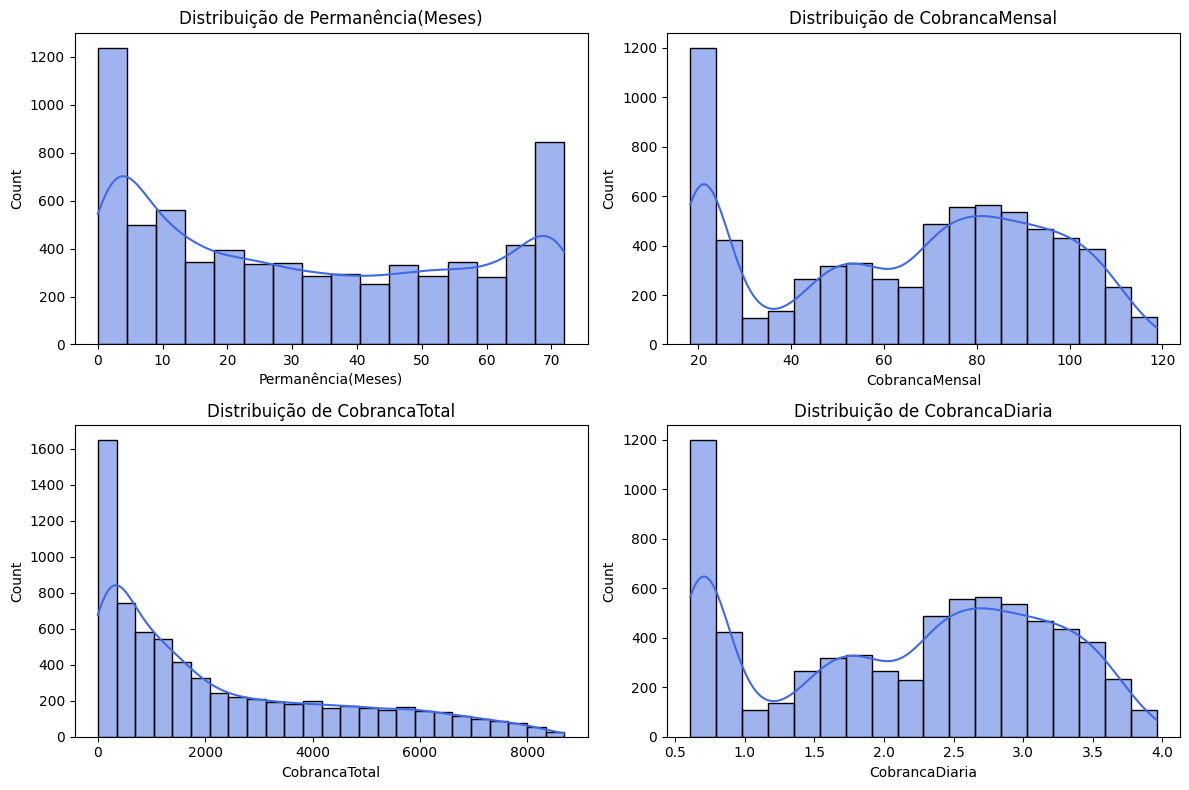

In [18]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
for ax, col in zip(axes.flatten(), numeric_cols):
    sns.histplot(df[col], kde=True, ax=ax, color='royalblue')
    ax.set_title(f"Distribuição de {col}")
    ax.set_xlabel(col)
plt.tight_layout()
plt.show()

In [19]:
#@title Distribuição da Evasão
df.loc[:, 'Evasao'] = df['Evasao'].astype(str)

# Contagem e proporção
evasao_counts = df['Evasao'].value_counts()
evasao_percent = df['Evasao'].value_counts(normalize=True) * 100

print("📊 Contagem de clientes por evasão:")
print(evasao_counts)
print("\n📊 Proporção de clientes por evasão (%):")
print(evasao_percent.round(2))

📊 Contagem de clientes por evasão:
Evasao
Não    5174
Sim    1869
Name: count, dtype: int64

📊 Proporção de clientes por evasão (%):
Evasao
Não    73.46
Sim    26.54
Name: proportion, dtype: float64


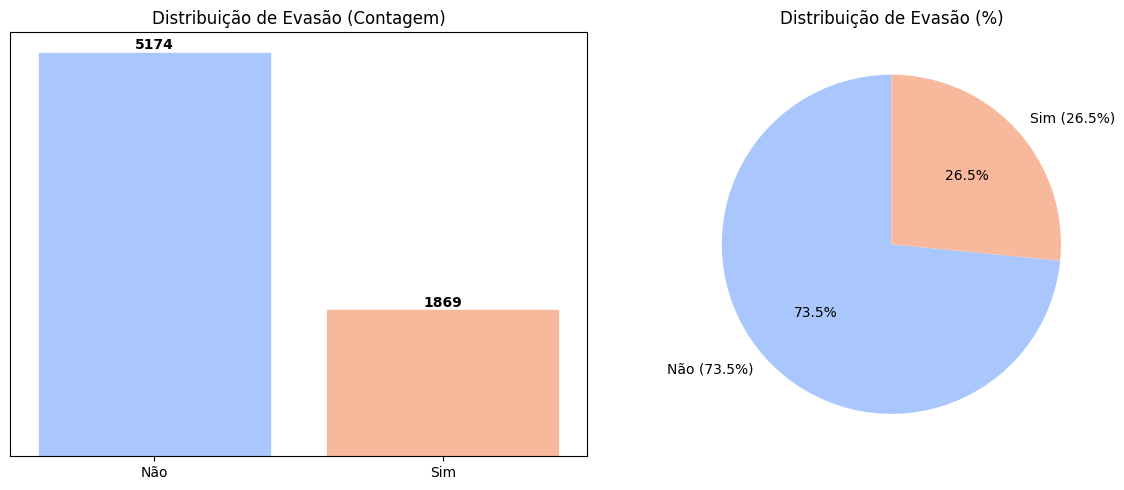

In [20]:
# Definir as cores com a paleta 'coolwarm' com número de cores igual ao número de categorias
cores = sns.color_palette('coolwarm', len(evasao_counts))

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Gráfico de barras com cor base neutra para evitar warning
sns.barplot(
    x=evasao_counts.index,
    y=evasao_counts.values,
    ax=axes[0],
    color='lightgray'  # cor base para depois colorir manualmente
)

# Colorir as barras manualmente com a paleta definida
for i, bar in enumerate(axes[0].patches):
    bar.set_color(cores[i])

axes[0].set_title('Distribuição de Evasão (Contagem)')

for i, v in enumerate(evasao_counts.values):
    axes[0].text(i, v + 50, f'{v}', ha='center', fontweight='bold')

# Remover ticks e valores do eixo y
axes[0].yaxis.set_visible(False)

# Remover título do eixo x
axes[0].set_xlabel('')

# Gráfico de pizza com as mesmas cores
axes[1].pie(
    evasao_counts,
    labels=[f"{label} ({perc:.1f}%)" for label, perc in zip(evasao_counts.index, evasao_percent)],
    colors=cores,
    autopct='%1.1f%%',
    startangle=90
)
axes[1].set_title('Distribuição de Evasão (%)')

plt.tight_layout()
plt.show()

## Contagem de Evasão por Variáveis Categóricas

In [21]:
if 'df' not in globals() or df.empty:
    raise ValueError("O DataFrame 'df' não está definido ou está vazio. Execute antes a célula de carregamento e limpeza.")

if 'Evasao' not in df.columns:
    raise ValueError("Coluna 'Evasao' não encontrada. Verifique a etapa de renomeação/tradução.")

# padroniza alvo
df = df.copy()
df['Evasao'] = df['Evasao'].astype(str).str.strip()
_map_evasao_bin = {'Sim': 1, 'Não': 0}
df['_EvasaoBin'] = df['Evasao'].map(_map_evasao_bin)
df_binario = df['_EvasaoBin']

# --------- escolhe categóricas ----------
candidatas = [
    'genero','Senior','Conjunge','Dependentes','Telefone','MultiplasLinhas',
    'ServicoInternet','Seguranca','BackupOnline','Protecao','Suporte',
    'TV','Filmes','Contrato','Fatura','MetodoPagamento'
]
cat_cols = [c for c in candidatas if c in df.columns]
if not cat_cols:
    raise ValueError("Nenhuma das variáveis categóricas esperadas foi encontrada.")

# --------- tabela longa: contagem + taxa de evasão ----------
linhas = []
for col in cat_cols:
    s = df[col].astype(str)
    cont = s.value_counts(dropna=False)
    valid = df['_EvasaoBin'].notna()
    taxa = df.loc[valid].groupby(s[valid])['_EvasaoBin'].mean()
    for cat in cont.index:
        linhas.append({
            'variavel': col,
            'categoria': str(cat),
            'contagem': int(cont.loc[cat]),
            'taxa_evasao_%': (float(taxa.get(cat, np.nan))*100.0) if pd.notna(taxa.get(cat, np.nan)) else np.nan
        })

resumo_long = pd.DataFrame(linhas).sort_values(['variavel','taxa_evasao_%'], ascending=[True, False]).reset_index(drop=True)
print("📄 Resumo por categoria — contagem e taxa de evasão (%):")
display(resumo_long)

📄 Resumo por categoria — contagem e taxa de evasão (%):


,variavel,categoria,contagem,taxa_evasao_%
0,BackupOnline,Não,3088,39.928756
1,BackupOnline,Sim,2429,21.531494
2,BackupOnline,Sem_Servico_Internet,1526,7.404980
3,Conjunge,Não,3641,32.957979
4,Conjunge,Sim,3402,19.664903
5,Contrato,Mensal,3875,42.709677
6,Contrato,Anual,1473,11.269518
7,Contrato,Bienal,1695,2.831858
8,Dependentes,Não,4933,31.279140
9,Dependentes,Sim,2110,15.450237


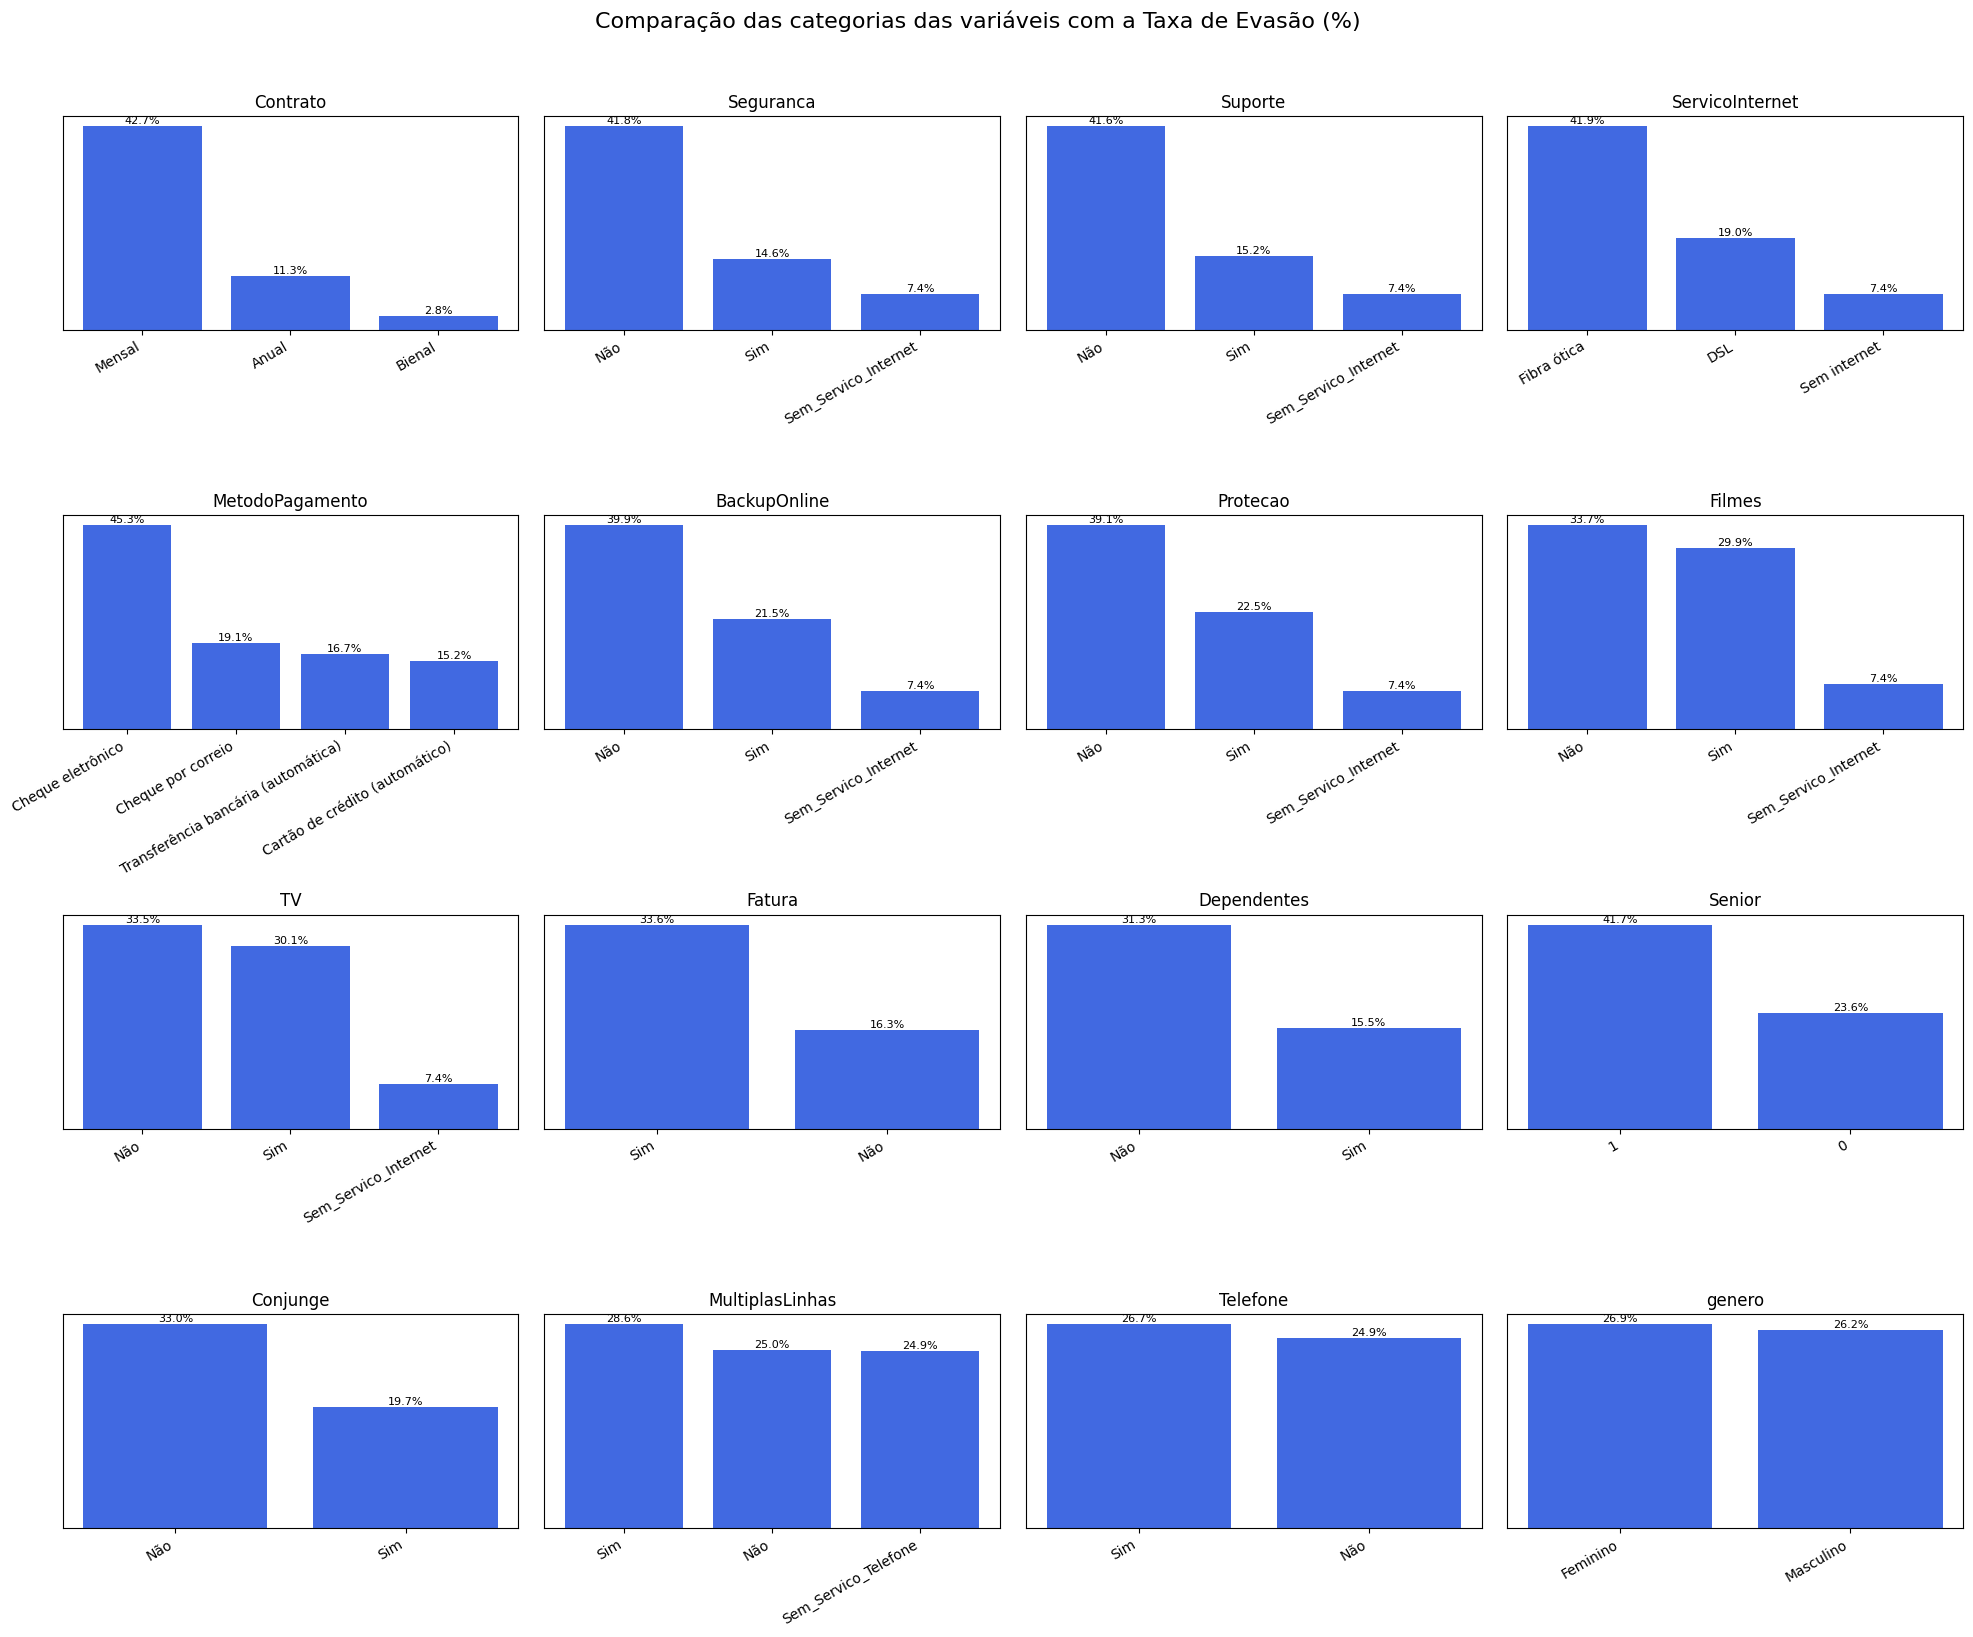

In [22]:
# Lista de variáveis categóricas
cat_cols = ['Contrato', 'Seguranca', 'Suporte', 'ServicoInternet',
            'MetodoPagamento', 'BackupOnline', 'Protecao', 'Filmes', 'TV', 'Fatura',
            'Dependentes', 'Senior', 'Conjunge', 'MultiplasLinhas', 'Telefone', 'genero']

# Inicializa lista de resultados
results = []

for col in cat_cols:
    if col in df.columns:
        # Tabela de contingência
        table = pd.crosstab(df[col], df['Evasao'])
        chi2, p, _, _ = chi2_contingency(table)
        n = table.sum().sum()
        cramers_v = np.sqrt(chi2 / (n * (min(table.shape)-1)))
        results.append({'variavel': col, 'cramers_v': cramers_v, 'p_valor_chi2': p})

# Criar DataFrame
estat_df = pd.DataFrame(results).sort_values(by='cramers_v', ascending=False)
estat_df

# Select top variables based on Cramer's V
top_vars = estat_df['variavel'].tolist()  # ou selecionar um subset, ex: estat_df['variavel'].head(5).tolist()

cols_per_row = 4
rows = math.ceil(len(top_vars) / cols_per_row)

fig, axes = plt.subplots(rows, cols_per_row, figsize=(cols_per_row * 5, rows * 4))
axes = axes.flatten()

# Título geral da figura
fig.suptitle("Comparação das categorias das variáveis com a Taxa de Evasão (%)", fontsize=16, y=1.02)

for idx, col in enumerate(top_vars):
    tmp = resumo_long[resumo_long['variavel'] == col].copy()
    tmp['categoria'] = tmp['categoria'].astype(str)
    tmp = tmp.sort_values('taxa_evasao_%', ascending=False)

    ax = axes[idx]
    ax.bar(range(len(tmp)), tmp['taxa_evasao_%'], color='royalblue')

    # Título individual simplificado
    ax.set_title(f"{col}", fontsize=12)

    # Remove ticks e label do eixo y
    ax.set_yticks([])
    ax.set_ylabel('')

    # Corrige os ticks do eixo x
    ax.set_xticks(range(len(tmp)))
    ax.set_xticklabels(tmp['categoria'], rotation=30, ha='right')

    # Remove label do eixo x
    ax.set_xlabel('')

    # Acrescenta valores acima das barras
    for i, v in enumerate(tmp['taxa_evasao_%']):
        if pd.notna(v):
            ax.text(i, v, f"{v:.1f}%", ha='center', va='bottom', fontsize=8)

# Remove eixos extras se houver
for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [23]:
def _cramers_v(confusion: pd.DataFrame) -> float:
    chi2, _, _, _ = chi2_contingency(confusion, correction=False)
    n = confusion.values.sum()
    r, k = confusion.shape
    return math.sqrt((chi2 / n) / (min(r - 1, k - 1))) if min(r, k) > 1 else np.nan

estat = []
for col in cat_cols:
    tab = pd.crosstab(df[col].astype(str), df['Evasao'])
    if tab.shape[0] < 2 or tab.shape[1] < 2:
        estat.append({'variavel': col, 'cramers_v': np.nan, 'p_valor_chi2': np.nan})
        continue
    chi2, p, _, _ = chi2_contingency(tab, correction=False)
    v = _cramers_v(tab)
    estat.append({'variavel': col, 'cramers_v': v, 'p_valor_chi2': p})

estat_df = pd.DataFrame(estat).sort_values('cramers_v', ascending=False).reset_index(drop=True)
print("\n📊 Força de associação com Evasão (Cramer's V e p-valor):")
display(estat_df)


📊 Força de associação com Evasão (Cramer's V e p-valor):


,variavel,cramers_v,p_valor_chi2
0,Contrato,0.410116,5.863038e-258
1,Seguranca,0.347400,2.661150e-185
2,Suporte,0.342916,1.443084e-180
3,ServicoInternet,0.322455,9.571788e-160
4,MetodoPagamento,0.303359,3.682355e-140
5,BackupOnline,0.292316,2.079759e-131
6,Protecao,0.281580,5.505219e-122
7,Filmes,0.230951,2.667757e-82
8,TV,0.230502,5.528994e-82
9,Fatura,0.191825,2.614597e-58


📊 Interpretação — Associação entre variáveis categóricas e Evasão (Churn)

O cálculo utilizou **V de Cramer** para medir a força de associação e **teste qui-quadrado** para avaliar a significância estatística.

---

 🔹 O que é o V de Cramer?
- Varia de **0 a 1**:
  - **0** → nenhuma associação (variável não ajuda a prever evasão)
  - **1** → associação perfeita
- Não é influenciado pelo tamanho da amostra (diferente do qui-quadrado bruto).
- **Regra prática**:
  - `0.00 – 0.10` → associação desprezível
  - `0.10 – 0.30` → associação fraca
  - `0.30 – 0.50` → associação moderada
  - `> 0.50` → associação forte

---

 🔹 O que é o p-valor do qui-quadrado?
- Mede se a associação é **estatisticamente significativa**.
- **p < 0.05** → associação provavelmente real, não por acaso.
- Com dataset grande, até associações fracas podem ter p-valores muito baixos.

---

 📌 Principais achados:

| Variável | V de Cramer | Força da Associação | Interpretação |
|----------|-------------|--------------------|--------------|
| **Contrato** | **0.41** | Moderada a forte | Tipo de contrato (mensal/anual/bienal) está fortemente ligado à evasão. Contratos mensais tendem a ter maior churn. |
| **Seguranca** | 0.35 | Moderada | Ausência de segurança online está associada a maior evasão. |
| **Suporte** | 0.34 | Moderada | Falta de suporte técnico contribui para churn. |
| **ServicoInternet** | 0.32 | Moderada | Tipo de internet influencia churn (ex.: sem internet ou DSL vs fibra). |
| **MetodoPagamento** | 0.30 | Moderada | Pagamentos manuais (cheque, boleto) têm mais churn que automáticos. |
| **BackupOnline** | 0.29 | Moderada | Não contratar backup online aumenta evasão. |
| **Protecao** | 0.28 | Moderada | Ausência de proteção extra associada ao cancelamento. |
| **Filmes** / **TV** | 0.23 | Fraca a moderada | Streaming influencia, mas menos que contrato/segurança. |
| **Fatura** | 0.19 | Fraca a moderada | Fatura sem papel pode ter relação com mais churn. |
| **Dependentes**, **Senior**, **Conjunge** | 0.15–0.16 | Fraca | Demografia tem influência menor. |
| **MultiplasLinhas**, **Telefone**, **genero** | < 0.05 | Desprezível | Não há relação relevante com evasão. |

---
 📌 Conclusões para o negócio:
- **Principais drivers de churn**:  
  **Contrato**, **Segurança Online**, **Suporte Técnico**, **Método de Pagamento**.
- **Perfil mais vulnerável**:  
  Cliente com contrato mensal, sem serviços adicionais de proteção, usando pagamento manual.
- **Ações recomendadas**:
  1. Incentivar contratos de longo prazo com benefícios.
  2. Oferecer pacotes de segurança/suporte com desconto.
  3. Migrar clientes para métodos de pagamento automáticos.


## Contagem de Evasão por Variáveis Numéricas

In [24]:
numeric_vars = ['CobrancaTotal', 'Permanência(Meses)', 'CobrancaMensal', 'CobrancaDiaria']
estatisticas = df.groupby('Evasao')[numeric_vars].agg(['mean', 'median', 'std', 'count']).T
print(estatisticas)

Evasao                             Não          Sim
CobrancaTotal      mean    2549.911442  1531.796094
                   median  1679.525000   703.550000
                   std     2329.954215  1890.822994
                   count   5174.000000  1869.000000
Permanência(Meses) mean      37.569965    17.979133
                   median    38.000000    10.000000
                   std       24.113777    19.531123
                   count   5174.000000  1869.000000
CobrancaMensal     mean      61.265124    74.441332
                   median    64.425000    79.650000
                   std       31.092648    24.666053
                   count   5174.000000  1869.000000
CobrancaDiaria     mean       2.042171     2.481378
                   median     2.147500     2.655000
                   std        1.036422     0.822202
                   count   5174.000000  1869.000000


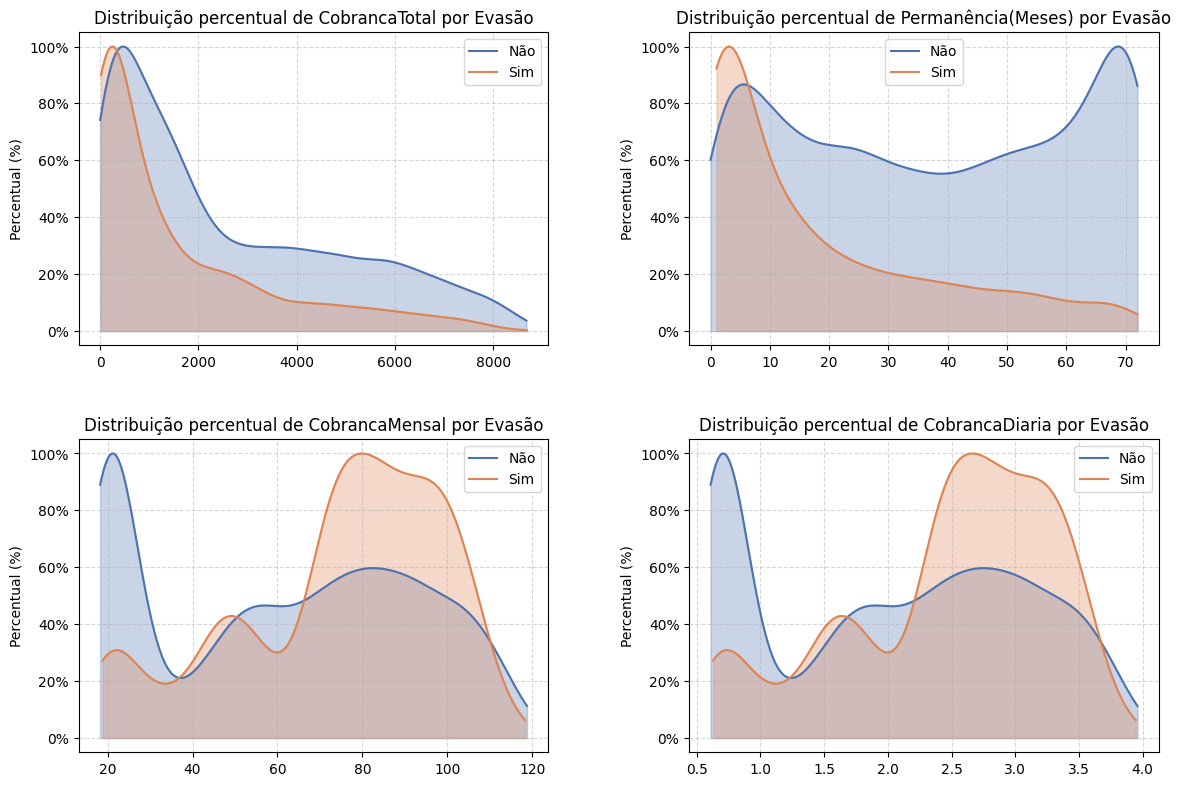

In [25]:
cols = 2
# Determine the number of rows needed for subplots
rows = math.ceil(len(numeric_vars) / cols)

fig, axes = plt.subplots(rows, cols, figsize=(12, 4*rows))
axes = axes.flatten()

for i, var in enumerate(numeric_vars):
    ax = axes[i]

    for evasion_class, color in zip(['Não', 'Sim'], ['#4c72b0', '#dd8452']):
        subset = df[df['Evasao'] == evasion_class][var].dropna()

        # Check if subset has enough data points for KDE
        if len(subset) > 1:
            kde = gaussian_kde(subset)

            x_min, x_max = subset.min(), subset.max()
            x_vals = np.linspace(x_min, x_max, 500)

            y_vals = kde(x_vals)

            # Normalize the KDE values to represent percentage
            y_vals_percent = (y_vals / y_vals.max()) * 100

            label = evasion_class

            ax.plot(x_vals, y_vals_percent, label=label, color=color)
            ax.fill_between(x_vals, 0, y_vals_percent, color=color, alpha=0.3)
        else:
            # Handle cases with insufficient data
            ax.text(0.5, 0.5, f"Dados insuficientes para {evasion_class}", horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, color='gray')


    ax.set_title(f'Distribuição percentual de {var} por Evasão')
    ax.set_ylabel('Percentual (%)')
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter())

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

fig.tight_layout()
fig.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, hspace=0.3, wspace=0.3)

plt.show()

#📄Relatorio Final

# 📊 Relatório Executivo – Análise de Evasão de Clientes (Churn) da Telecom X

## 🎯 Objetivo
Analisar o comportamento dos clientes da Telecom X e identificar os principais fatores que influenciam a evasão (churn), propondo estratégias para retenção e redução de cancelamentos.

---

## 🧹 Limpeza e Tratamento de Dados
- Importação dos dados via API (formato JSON).
- Padronização de colunas e tradução de valores.
- Tratamento de valores ausentes e exclusão de duplicatas.
- Conversão de tipos e criação da coluna `CobrancaDiaria`.

---

## 📈 Análise Exploratória
- **Taxa de evasão**: 26.54% dos clientes cancelaram o serviço.
- **Contratos mensais** apresentam maior churn.
- **Serviços adicionais** como suporte técnico e segurança reduzem evasão.
- **Cobrança mensal elevada** está associada a maior risco de cancelamento.

---

## 🔍 Correlações Relevantes (V de Cramer)
| Variável            | V de Cramer | Associação         |
|---------------------|-------------|--------------------|
| Contrato            | 0.41        | Moderada a forte   |
| Segurança Online    | 0.35        | Moderada           |
| Suporte Técnico     | 0.34        | Moderada           |
| Método de Pagamento | 0.30        | Moderada           |
| Backup/Proteção     | ~0.28–0.29  | Moderada           |
| Streaming (Filmes/TV) | ~0.23     | Fraca a moderada   |
| Demografia          | < 0.16      | Fraca ou desprezível |

---

## 💡 Insights Estratégicos
- **Contrato mensal** é o principal fator de risco.
- **Serviços adicionais** influenciam positivamente na retenção.
- **Pagamentos automáticos** estão associados à fidelização.

---

## ✅ Recomendações
1. Incentivar contratos anuais/bienais com benefícios.
2. Oferecer pacotes com serviços de valor agregado.
3. Migrar clientes para métodos de pagamento automáticos.
4. Monitorar clientes com alto risco de churn.
5. Realizar pesquisas de satisfação com clientes de alta cobrança.


# Extra

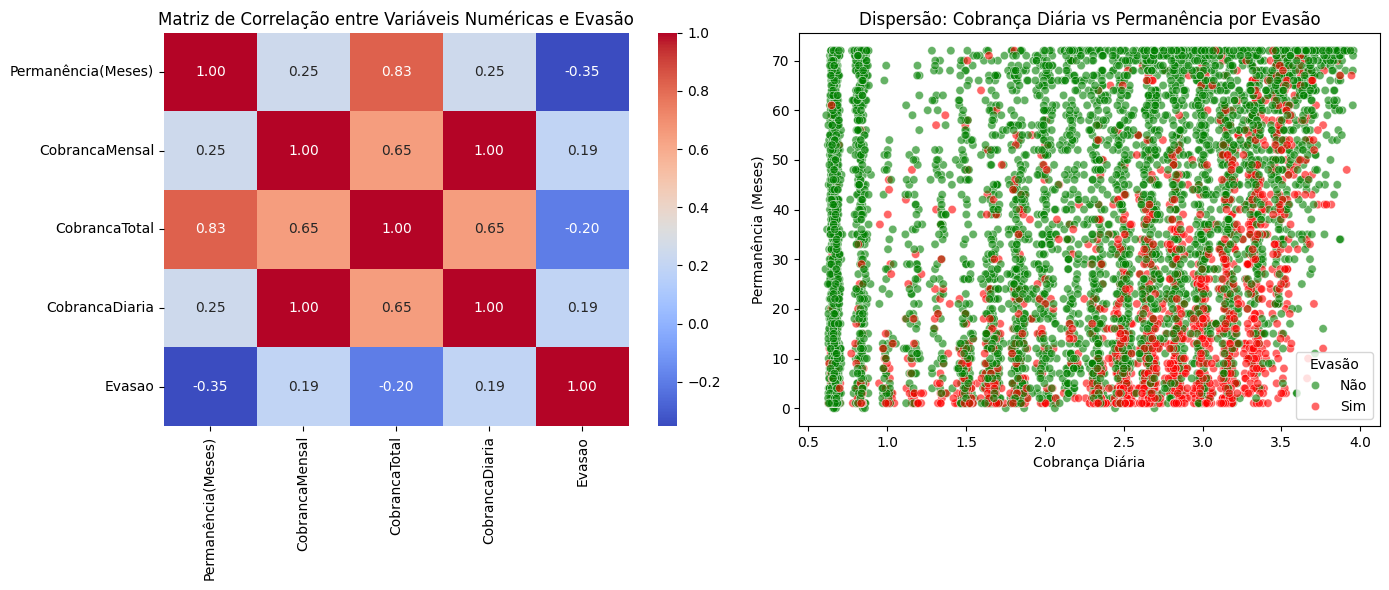

In [26]:
# Copiar dataframe
df_corr = df.copy()

# Garantir que Evasao é string
df_corr['Evasao'] = df_corr['Evasao'].astype(str)

# Selecionar colunas numéricas + evasão
numeric_cols = ['Permanência(Meses)', 'CobrancaMensal', 'CobrancaTotal', 'CobrancaDiaria']

# Criar cópia para correlação, convertendo Evasao para 0/1
df_corr_numeric = df_corr[numeric_cols + ['Evasao']].copy()
df_corr_numeric['Evasao'] = df_corr_numeric['Evasao'].map({'Não': 0, 'Sim': 1})

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 1️⃣ Heatmap
sns.heatmap(
    df_corr_numeric.corr(),
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    cbar=True,
    ax=axes[0]
)
axes[0].set_title("Matriz de Correlação entre Variáveis Numéricas e Evasão")

# 2️⃣ Scatter plot com cores fixas
sns.scatterplot(
    data=df_corr,
    x='CobrancaDiaria',
    y='Permanência(Meses)',
    hue='Evasao',
    hue_order=['Não', 'Sim'],           # garante ordem consistente
    palette={'Não':'green', 'Sim':'red'},  # cores fixas
    alpha=0.6,
    ax=axes[1]
)
axes[1].set_xlabel("Cobrança Diária")
axes[1].set_ylabel("Permanência (Meses)")
axes[1].set_title("Dispersão: Cobrança Diária vs Permanência por Evasão")
axes[1].legend(title='Evasão')

plt.tight_layout()
plt.show()

In [27]:
# Remove the temporary binary churn column
if '_EvasaoBin' in df.columns:
    df = df.drop('_EvasaoBin', axis=1)

# Export the dataframe to a CSV file
df.to_csv('telecomx_processed_data.csv', index=False)